Taking contiguous subset from index 118280 to 123280 (Total samples: 261120)
Using all samples (including silences). Total: 5000
Computing UMAP...


/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/georgev/anaconda3/envs/tweetybert/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/3n/cbt5h8qx7ggdhzsmwzy8nd040000gq/T/ipykernel_94767/130893171.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved plot to umap_poster_viz.svg


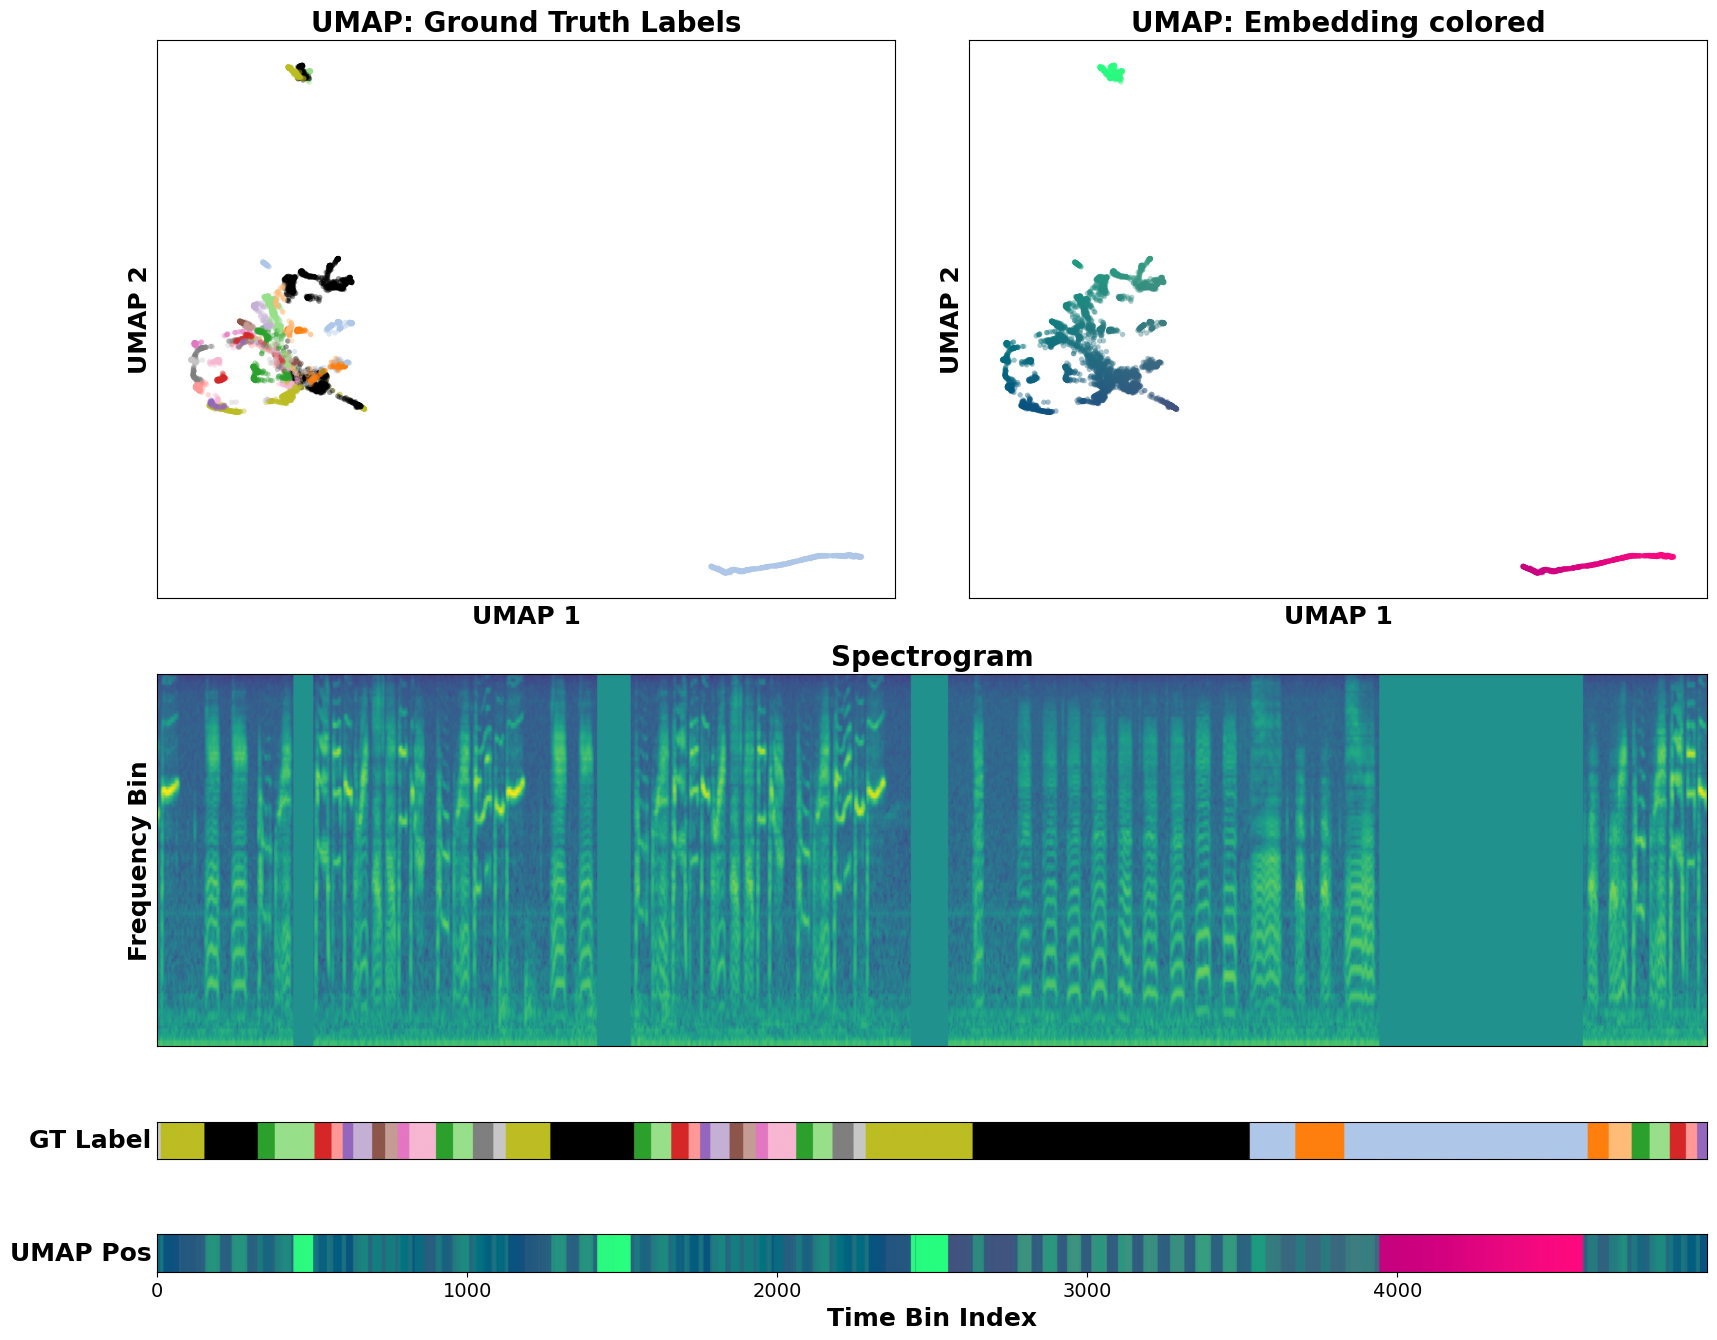

In [46]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Configuration ---
# Set font sizes for "poster ready" look
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 22
})

# Load data
embedding_path = "/Users/georgev/Documents/codebases/TinyBird/results/eval_experiments/tinybird_pretrain_20251122_091539/bengalese_finch/bird2/embeddings.npz"

data = np.load(embedding_path)

emb = data["encoded_embeddings_after_pos_removal"]
labels = data["labels_downsampled"]
spectrogram = data["spectrograms"]

# Determine silence label
# Based on extract_embedding.py, silence is -1.
silence_label = -1

# Subset a random contiguous chunk of N samples
N = 5000 # Increased N to ensure enough data after silence removal
total_samples = emb.shape[0]
max_start = total_samples - N

if max_start > 0:
    start_idx = np.random.randint(0, max_start)
else:
    start_idx = 0

end_idx = start_idx + N
print(f"Taking contiguous subset from index {start_idx} to {end_idx} (Total samples: {total_samples})")

emb_subset = emb[start_idx:end_idx]
labels_subset = labels[start_idx:end_idx]
spec_subset = spectrogram[start_idx:end_idx]

# --- DO NOT Remove Intersyllabic Silences (as per new request) ---
# We keep everything including -1 labels
emb_filtered = emb_subset
labels_filtered = labels_subset
spec_filtered = spec_subset

print(f"Using all samples (including silences). Total: {len(labels_filtered)}")

# Compute UMAP
print("Computing UMAP...")
reducer = umap.UMAP(random_state=42, n_neighbors=100, min_dist=0.1, metric='cosine')
emb_umap = reducer.fit_transform(emb_filtered)

# --- Prepare Colors ---

# 1. Ground Truth Colors 
# Logic: Label 0 -> Black. Others -> Tab20 
unique_labels = np.unique(labels_filtered)
cmap = plt.get_cmap('tab20') 

# Create color array
c_gt = np.zeros((len(labels_filtered), 4)) # RGBA

# Helper to get color from label
def get_label_color(lbl):
    if lbl == 0:
        return [0.0, 0.0, 0.0, 1.0] # Black
    elif lbl == -1:
        # Silence default (if not merged)
        return [0.9, 0.9, 0.9, 1.0] # Light Gray
    else:
        return cmap((lbl) % 20)

# Forward fill for visual continuity (approx "merge with surrounding")
# We'll iterate and keep track of last non-silence label
last_valid_color = [0.9, 0.9, 0.9, 1.0]
c_gt_filled = np.zeros((len(labels_filtered), 4))

for i in range(len(labels_filtered)):
    lbl = labels_filtered[i]
    if lbl != -1:
        color = get_label_color(lbl)
        last_valid_color = color
        c_gt[i] = color
        c_gt_filled[i] = color
    else:
        # It's silence
        c_gt[i] = [0.9, 0.9, 0.9, 0.3] # Gray, semi-transparent for scatter
        c_gt_filled[i] = last_valid_color # Forward filled for bar (or scatter?)

# 2. Position Colors (Map 2D UMAP to RGB)
min_u = emb_umap.min(axis=0)
max_u = emb_umap.max(axis=0)
norm_umap = (emb_umap - min_u) / (max_u - min_u)

c_pos = np.zeros((len(labels_filtered), 3))
c_pos[:, 0] = norm_umap[:, 0] 
c_pos[:, 1] = norm_umap[:, 1]
c_pos[:, 2] = 0.5 

# --- Plotting ---
fig = plt.figure(figsize=(20, 16)) # Poster ready size
gs = gridspec.GridSpec(4, 2, height_ratios=[3, 2, 0.2, 0.2], hspace=0.3, wspace=0.1)

# 1. UMAP: Ground Truth Labels
ax_umap_gt = fig.add_subplot(gs[0, 0])
# Use filled colors (merging silence)
# ADDED: alpha=0.4 for opacity
scatter_gt = ax_umap_gt.scatter(emb_umap[:, 0], emb_umap[:, 1], c=c_gt_filled, s=15, alpha=0.4, edgecolors='none')
ax_umap_gt.set_title("UMAP: Ground Truth Labels", fontweight='bold')

# --- UPDATED: Add UMAP 1/2 axis labels and remove ticks ---
ax_umap_gt.set_xlabel("UMAP 1", fontweight='bold')
ax_umap_gt.set_ylabel("UMAP 2", fontweight='bold')
ax_umap_gt.set_xticks([])
ax_umap_gt.set_yticks([])


# 2. UMAP: Embedding colored (Position)
ax_umap_pos = fig.add_subplot(gs[0, 1])
# ADDED: alpha=0.4 for opacity
scatter_pos = ax_umap_pos.scatter(emb_umap[:, 0], emb_umap[:, 1], c=c_pos, s=15, alpha=0.4, edgecolors='none')
ax_umap_pos.set_title("UMAP: Embedding colored", fontweight='bold')

# --- UPDATED: Add UMAP 1/2 axis labels and remove ticks ---
ax_umap_pos.set_xlabel("UMAP 1", fontweight='bold')
ax_umap_pos.set_ylabel("UMAP 2", fontweight='bold')
ax_umap_pos.set_xticks([])
ax_umap_pos.set_yticks([])


# 3. Spectrogram (Full with silences)
ax_spec = fig.add_subplot(gs[1, :])
# --- UPDATED: Use 'viridis' colormap ---
ax_spec.imshow(spec_filtered.T, aspect='auto', origin='lower', cmap='viridis')
ax_spec.set_title("Spectrogram", fontweight='bold')
ax_spec.set_ylabel("Frequency Bin", fontweight='bold')
ax_spec.set_xticks([]) 
ax_spec.set_yticks([])

# 4. Color Bar: Ground Truth
ax_bar_gt = fig.add_subplot(gs[2, :])
ax_bar_gt.imshow(c_gt_filled[np.newaxis, :, :], aspect='auto')
ax_bar_gt.set_ylabel("GT Label", rotation=0, ha='right', va='center', fontweight='bold')
ax_bar_gt.set_yticks([])
ax_bar_gt.set_xticks([])

# 5. Color Bar: Position in UMAP
ax_bar_pos = fig.add_subplot(gs[3, :])
ax_bar_pos.imshow(c_pos[np.newaxis, :, :], aspect='auto')
ax_bar_pos.set_ylabel("UMAP Pos", rotation=0, ha='right', va='center', fontweight='bold')
ax_bar_pos.set_yticks([])
ax_bar_pos.set_xlabel("Time Bin Index", fontweight='bold')

plt.tight_layout()

# Save as SVG
svg_path = "umap_poster_viz.svg"
plt.savefig(svg_path, format='svg', bbox_inches='tight')
print(f"Saved plot to {svg_path}")

plt.show()